In [1]:
# modify these addresses as needed
from utils import local_ip
masque_addr = ("128.110.216.104", 4433)
echo_addr = (local_ip, 12345)
# local_addr is assigned dynamically

'''
Run echo server on a machine with Python and public IP address:

cd ~
rm -rf ~/masque-linux
sudo git clone https://github.com/dx2102/masque-linux
cd ~/masque-linux
sudo chmod a+rwx -R .
clear
python3 echo_server.py --quiet




Run masquerade on a linux x86 machine with public IP address:
rm -rf ~/masque-linux
sudo git clone https://github.com/dx2102/masque-linux
cd ~/masque-linux
sudo chmod a+rwx -R .
clear

ifconfig -a
export RUST_LOG=debug
./server 0.0.0.0:4433
'''
None

In [2]:
import time
import os
import socket
import threading
import queue
import asyncio
import aioquic

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from utils import start

In [3]:
class Connection:
    '''
    This is an abstract base class for connections.
    We will implement four subclasses:
    - SimpleQueue()
    - LocalUDP()
    - DirectUDP()
    - DirectTCP()
    - MasqueUDP()
    - MasqueTCP()
    They will use global variables: masque_addr, echo_addr
    For simplicity, this class is synchronous.
    TCP connections will use \n as separator.
    '''
    def __init__(self, *args, **kwargs):
        raise NotImplementedError
    
    def send(self, data: bytes):
        raise NotImplementedError
    
    def recv(self) -> bytes:
        raise NotImplementedError

In [4]:
def benchmark(
        conn, experiment_name = 'experiment',
        payload = '', n = 100, gap = 0.01
    ):
    '''
    Benchmark any Connection object.
    Concatenate current time and a space to data, and send it n times.
    Record delays of each packet.
    Plot the result and save data to ./results/experiment_name.csv
    '''
    delays = {}
    @start
    def recv():
        for i in range(n):
            data = conn.recv().decode()
            # split with the first space
            recv_time = time.time()
            send_time, data = data.split(' ', 1)
            send_time = float(send_time)
            delay = recv_time - send_time
            if send_time not in delays:
                raise Exception(
                    'Received a packet that was not sent: ',
                    send_time, delays
                )
            if delays[send_time] is not None:
                raise Exception(
                    'Received a packet that was already received: ',
                    send_time, delays
                )
            delays[send_time] = delay
            # print(send_time % 1, recv_time % 1, delay % 1, delays)
    @start
    def send():
        for i in range(n):
            send_time = time.time()
            data = (str(send_time) + ' ' + payload).encode()
            conn.send(data)
            delays[send_time] = None
            time.sleep(gap)
    # only wait until send is done, then wait for 0.5 seconds
    # all packets that have not arrived will be assumed lost
    send.join()
    time.sleep(0.5)

    if not os.path.exists('./results'):
        os.makedirs('./results')

    # csv
    file = open(f'./results/{experiment_name}.csv', 'w')
    file.write('send_time, delay\n')
    for send_time, delay in delays.items():
        file.write(f'{send_time}, {delay}\n')
    file.close()
    
    # plot
    print(delays)
    delays_lst = [delay 
        for send_time, delay in sorted(delays.items())]
    print(delays_lst)
    plt.plot(delays_lst)
    # red spots are lost packets
    lost_idx = [i for i, delay in enumerate(delays_lst) if delay is None]
    plt.scatter(lost_idx, [0 for i in lost_idx], c='r', s=3)
    plt.show()
    plt.savefig(f'./results{experiment_name}.png')

    

{1701336654.3519187: 0.0, 1701336654.3678756: 0.0, 1701336654.383835: 0.0, 1701336654.3997908: 0.0, 1701336654.415749: 0.0, 1701336654.431705: 0.0, 1701336654.4476614: 0.0, 1701336654.464627: 0.0, 1701336654.4785793: 0.0, 1701336654.4955342: 0.0, 1701336654.5124965: 0.0, 1701336654.5354273: 0.0, 1701336654.5543766: 0.0, 1701336654.5583668: 0.0, 1701336654.5743248: 0.0, 1701336654.5962703: 0.0, 1701336654.622196: 0.0009965896606445312, 1701336654.6381538: 0.0, 1701336654.6541102: 0.0, 1701336654.6700692: 0.0, 1701336654.6860244: 0.0, 1701336654.7019825: 0.0, 1701336654.7179399: 0.0, 1701336654.733898: 0.0, 1701336654.749855: 0.0, 1701336654.7658145: 0.0, 1701336654.782767: 0.0009980201721191406, 1701336654.7977312: 0.0, 1701336654.8136833: 0.0, 1701336654.8306382: 0.0010044574737548828, 1701336654.8466122: 0.00098419189453125, 1701336654.8615634: 0.0, 1701336654.8785188: 0.000989675521850586, 1701336654.8954654: 0.0, 1701336654.908431: 0.0, 1701336654.9243872: 0.0, 1701336654.9403446: 0

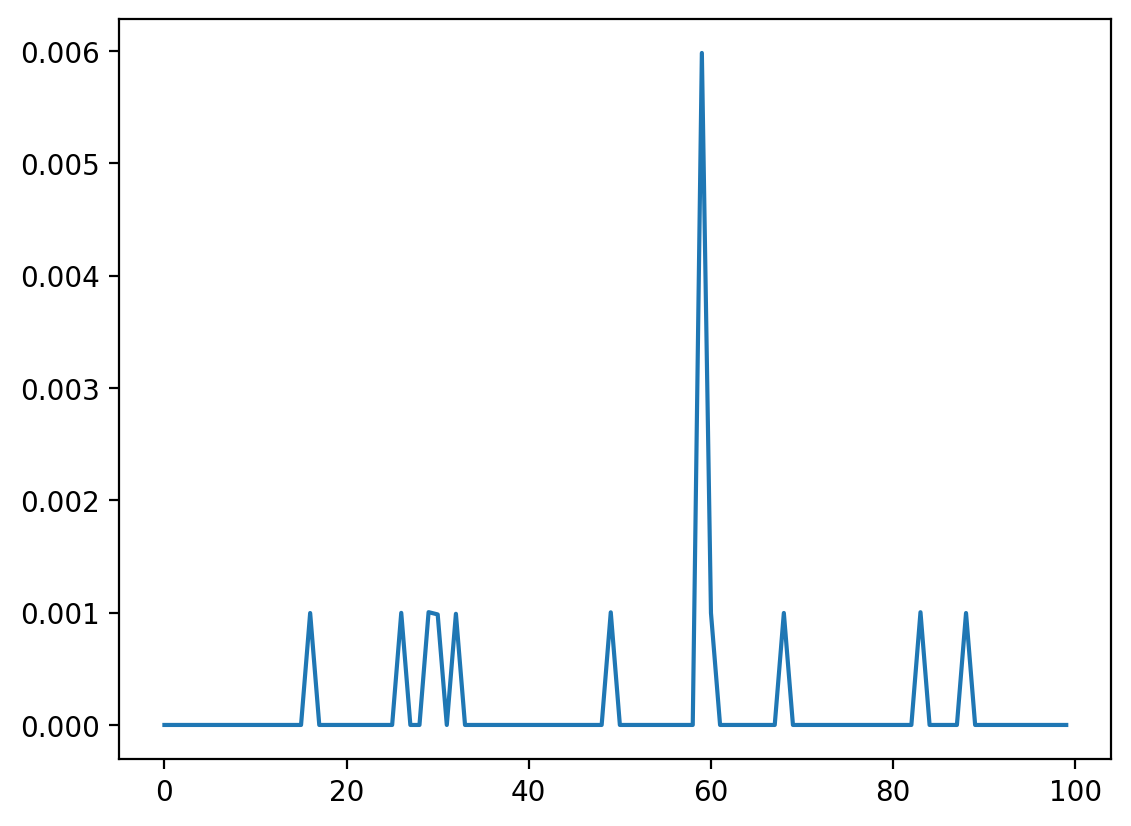

<Figure size 640x480 with 0 Axes>

In [5]:
class SimpleQueue(Connection):
    '''
    This is a simple queue that can be used to test the benchmark function.
    '''
    def __init__(self, *args, **kwargs):
        self.queue = queue.Queue()
    
    def send(self, data: bytes):
        self.queue.put(data)
    
    def recv(self) -> bytes:
        result = self.queue.get()
        return result
    
benchmark(
    SimpleQueue(), 'simple_queue', 
    payload='hello world', 
)